(125689, 12)
Year                                                0
Country of origin                                   0
Country of origin (ISO)                             0
Country of asylum                                   0
Country of asylum (ISO)                             0
Refugees under UNHCR's mandate                      0
Asylum-seekers                                      0
IDPs of concern to UNHCR                            0
Other people in need of international protection    0
Stateless persons                                   0
Host Community                                      0
Others of concern                                   0
dtype: int64


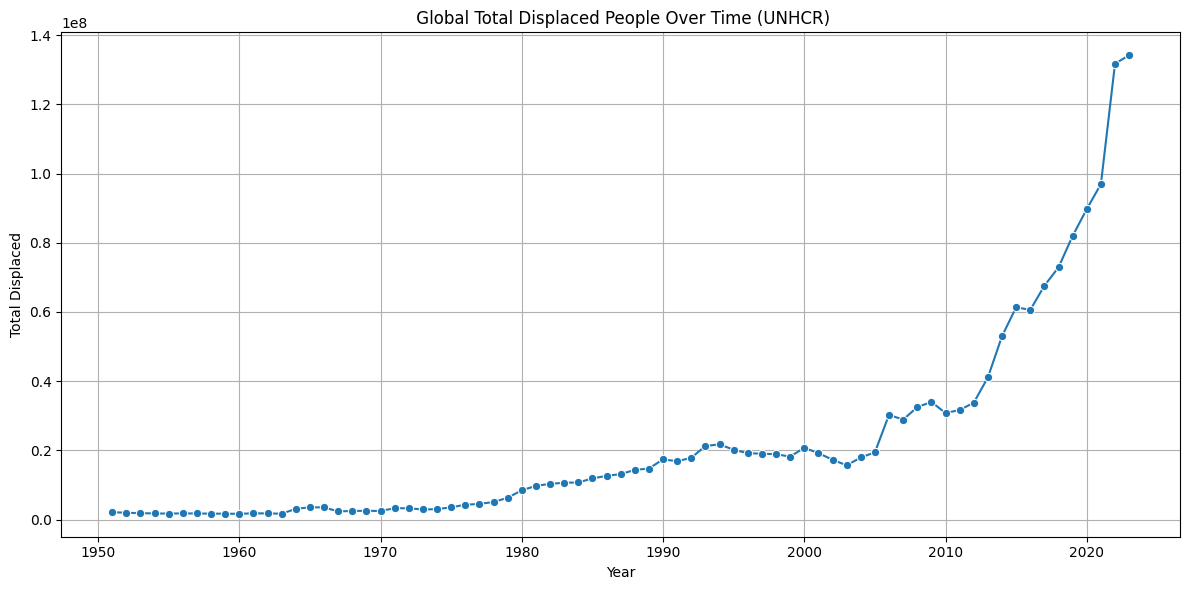

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv('../data/cleaned_refugee_data.csv')

# Check shape & nulls
print(df.shape)
print(df.isnull().sum())

# Total refugees per year globally
df['Total Displaced'] = (
    df["Refugees under UNHCR's mandate"] +
    df["Asylum-seekers"] +
    df["IDPs of concern to UNHCR"] +
    df["Other people in need of international protection"] +
    df["Stateless persons"] +
    df["Host Community"] +
    df["Others of concern"]
)

yearly = df.groupby("Year")["Total Displaced"].sum().reset_index()

# Plot trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly, x="Year", y="Total Displaced", marker="o")
plt.title(" Global Total Displaced People Over Time (UNHCR)")
plt.xlabel("Year")
plt.ylabel("Total Displaced")
plt.grid(True)
plt.tight_layout()
plt.show()


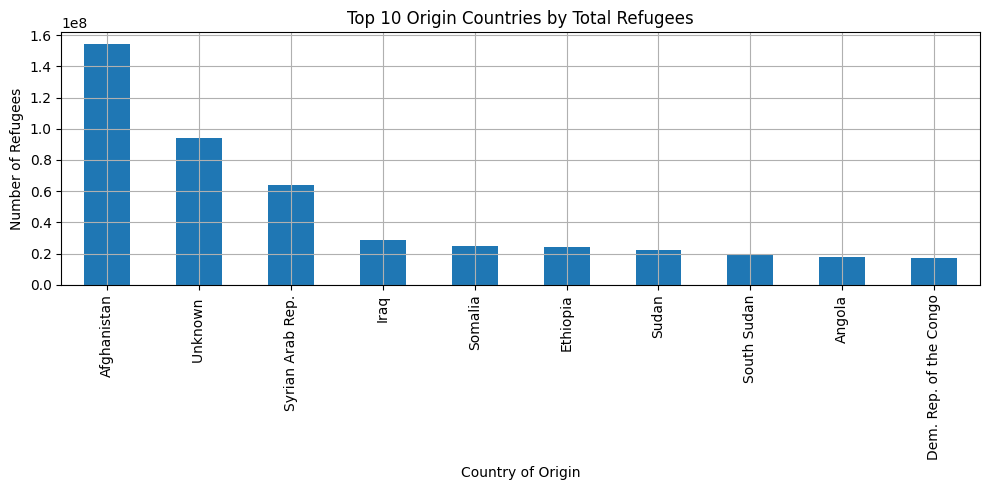

In [2]:
top_origin_countries = df.groupby("Country of origin")["Refugees under UNHCR's mandate"].sum().sort_values(ascending=False).head(10)

top_origin_countries.plot(kind='bar', figsize=(10, 5), title="Top 10 Origin Countries by Total Refugees")
plt.ylabel("Number of Refugees")
plt.xlabel("Country of Origin")
plt.grid(True)
plt.tight_layout()
plt.show()


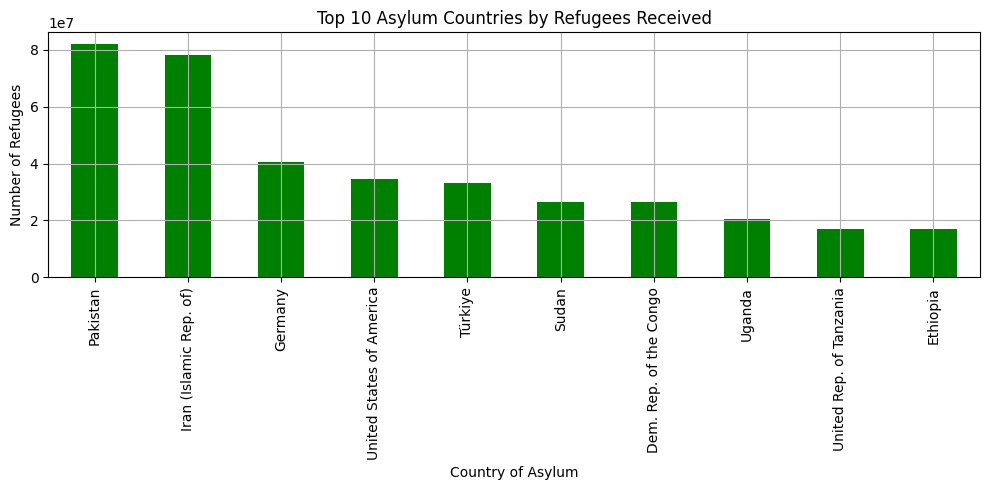

In [3]:
top_asylum_countries = df.groupby("Country of asylum")["Refugees under UNHCR's mandate"].sum().sort_values(ascending=False).head(10)

top_asylum_countries.plot(kind='bar', color='green', figsize=(10, 5), title="Top 10 Asylum Countries by Refugees Received")
plt.ylabel("Number of Refugees")
plt.xlabel("Country of Asylum")
plt.grid(True)
plt.tight_layout()
plt.show()


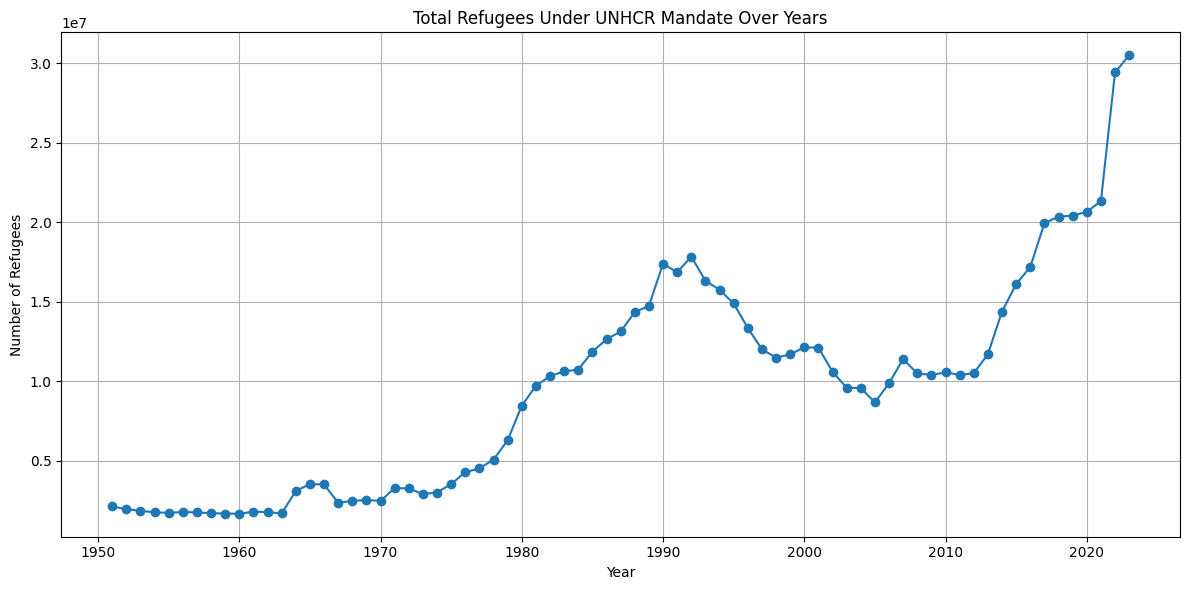

In [4]:
refugees_per_year = df.groupby("Year")["Refugees under UNHCR's mandate"].sum()

refugees_per_year.plot(figsize=(12, 6), title="Total Refugees Under UNHCR Mandate Over Years", marker='o')
plt.ylabel("Number of Refugees")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Total refugees by year
yearly_totals = df.groupby("Year")["Refugees under UNHCR's mandate"].sum().reset_index()

# Show year with highest refugee count
max_year = yearly_totals.loc[yearly_totals["Refugees under UNHCR's mandate"].idxmax()]

# Show top 5 years with highest refugee displacement
top_5_years = yearly_totals.sort_values(by="Refugees under UNHCR's mandate", ascending=False).head()

# Show top 5 origin countries across all years
top_origins_total = df.groupby("Country of origin")["Refugees under UNHCR's mandate"].sum().sort_values(ascending=False).head()

# Show top 5 asylum countries across all years
top_asylums_total = df.groupby("Country of asylum")["Refugees under UNHCR's mandate"].sum().sort_values(ascending=False).head()

print("🔴 Year with highest global refugee count:\n", max_year, "\n")
print("📈 Top 5 highest refugee years:\n", top_5_years, "\n")
print("🌍 Top 5 countries of origin:\n", top_origins_total, "\n")
print("🛂 Top 5 asylum countries:\n", top_asylums_total)


🔴 Year with highest global refugee count:
 Year                                  2023
Refugees under UNHCR's mandate    30510633
Name: 72, dtype: int64 

📈 Top 5 highest refugee years:
     Year  Refugees under UNHCR's mandate
72  2023                        30510633
71  2022                        29429078
70  2021                        21327285
69  2020                        20661846
68  2019                        20414669 

🌍 Top 5 countries of origin:
 Country of origin
Afghanistan         154109705
Unknown              94281349
Syrian Arab Rep.     63926208
Iraq                 28899291
Somalia              25037710
Name: Refugees under UNHCR's mandate, dtype: int64 

🛂 Top 5 asylum countries:
 Country of asylum
Pakistan                    82098736
Iran (Islamic Rep. of)      78354616
Germany                     40380144
United States of America    34377019
Türkiye                     33311115
Name: Refugees under UNHCR's mandate, dtype: int64


In [6]:
# Prepare dataset for modeling
df_model = df[["Year", "Country of origin", "Country of asylum", "Refugees under UNHCR's mandate"]]

# Check for missing values
assert df_model.isnull().sum().sum() == 0, "There are missing values in the model input data"

# Aggregate refugee flow per route per year
df_model_grouped = df_model.groupby(["Year", "Country of origin", "Country of asylum"]).sum().reset_index()

# Preview grouped data
print(df_model_grouped.head())



   Year Country of origin     Country of asylum  \
0  1951          Unknown              Australia   
1  1951          Unknown                Austria   
2  1951          Unknown                Belgium   
3  1951          Unknown                 Canada   
4  1951          Unknown   China, Hong Kong SAR   

   Refugees under UNHCR's mandate  
0                          180000  
1                          282000  
2                           55000  
3                          168511  
4                           30000  


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

# Encode categorical variables
le_origin = LabelEncoder()
le_asylum = LabelEncoder()

# Ensure no nulls in categorical columns before encoding
assert df_model_grouped[["Country of origin", "Country of asylum"]].isnull().sum().sum() == 0, "Missing values in categorical columns"

df_model_grouped["origin_encoded"] = le_origin.fit_transform(df_model_grouped["Country of origin"])
df_model_grouped["asylum_encoded"] = le_asylum.fit_transform(df_model_grouped["Country of asylum"])

# Features and target
X = df_model_grouped[["Year", "origin_encoded", "asylum_encoded"]]
y = df_model_grouped["Refugees under UNHCR's mandate"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print data split info
print("Data prepared.")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Data prepared.
Training samples: 100551, Testing samples: 25138


In [8]:
print(df_model_grouped[["Country of origin", "origin_encoded", "Country of asylum", "asylum_encoded"]].head())



  Country of origin  origin_encoded     Country of asylum  asylum_encoded
0          Unknown              204             Australia               9
1          Unknown              204               Austria              10
2          Unknown              204               Belgium              17
3          Unknown              204                Canada              32
4          Unknown              204  China, Hong Kong SAR              38


In [9]:
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (125689, 3)
Target shape: (125689,)


In [10]:
print("🚀 Training model...")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming X and y are defined (features and target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Model trained")
print(f"📉 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.4f}")


🚀 Training model...
✅ Model trained
📉 MAE: 1704.11
📈 R² Score: 0.9421


In [ ]:
!pip install scikit-learn

